# CELL 1: Install Required Packages

Triple SMA Trading Strategy with QuantStats for Google Colab
============================================================

This notebook implements the Triple SMA (20/50/200) trading strategy
with comprehensive performance analytics using QuantStats.

Run each cell sequentially for best results.

In [95]:
print("📦 Installing required packages...")

# Core packages
!pip install pandas>=1.3.0 numpy>=1.21.0 matplotlib>=3.4.0

# IBKR API
!pip install --upgrade pip
!pip install ibapi>=9.81.1

# Performance analytics
!pip install quantstats>=0.0.59

# Additional packages
!pip install yfinance>=0.1.87 requests

print("✅ All packages installed successfully!")


📦 Installing required packages...
✅ All packages installed successfully!


# CELL 2: Import Libraries and Setup

In [96]:
# Verify installation and import libraries
try:
    import datetime
    import time
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from ibapi.client import EClient
    from ibapi.wrapper import EWrapper
    from ibapi.contract import Contract
    from ibapi.order import Order
    import threading
    import functools
    import quantstats as qs
    import requests
    import json
    import socket

    print("✅ All required packages imported successfully!")

except ImportError as e:
    print(f"❌ Package import failed: {e}")
    print("Please run the installation cell above and try again.")

# Enable QuantStats Jupyter integration
qs.extend_pandas()

# Set matplotlib style for better visualizations - Colab compatible
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Fix font warnings in Colab - Complete suppression
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'sans-serif']

# Completely suppress all matplotlib font warnings
import warnings
import logging
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', message='.*font.*')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

print("🎨 Matplotlib styling configured (Colab compatible)")
print("📊 QuantStats integration enabled")

✅ All required packages imported successfully!
🎨 Matplotlib styling configured (Colab compatible)
📊 QuantStats integration enabled


# CELL 3: IBKR API Wrapper Class

In [97]:
class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
        self.data = []  # Initialize variable to store candle data
        self.positions = {}  # Dictionary to store current positions
        self.data_received = False

    def historicalData(self, reqId, bar):
        # Called when historical data is received
        self.data.append([bar.date, bar.open, bar.high, bar.low, bar.close, bar.volume])

    def historicalDataEnd(self, reqId, start, end):
        # Called when all historical data has been received
        print(f"📈 Historical data received from {start} to {end}")
        self.data_received = True

    def position(self, account, contract, position, avgCost):
        # Called when position information is received
        super().position(account, contract, position, avgCost)
        key = contract.symbol
        self.positions[key] = position
        print(f"💼 Current position for {key}: {position} shares at avg cost of {avgCost}")

    def nextValidId(self, orderId):
        # Called when connection is established and next valid order ID is received
        super().nextValidId(orderId)
        self.nextOrderId = orderId
        print(f"🔗 Connected to TWS. Next valid order ID: {orderId}")

    def error(self, reqId, errorCode, errorString):
        # Called when an error occurs
        if errorCode != 2104 and errorCode != 2106:  # Ignore common info messages
            print(f"⚠️ Error {errorCode}: {errorString}")

    def orderStatus(self, orderId, status, filled, remaining, avgFillPrice,
                   permId, parentId, lastFillPrice, clientId, whyHeld, mktCapPrice):
        # Called when order status changes
        print(f"📋 Order {orderId} status: {status}, filled: {filled}, remaining: {remaining}, price: {avgFillPrice}")

print("✅ IBKR API wrapper class defined")

✅ IBKR API wrapper class defined


# CELL 4: Utility Functions

In [98]:
def create_contract(symbol, secType='STK', exchange='SMART', currency='USD'):
    """Create a contract object for a specific security"""
    contract = Contract()
    contract.symbol = symbol
    contract.secType = secType
    contract.exchange = exchange
    contract.currency = currency
    return contract

def create_order(action, quantity, order_type='MKT'):
    """Create an order object"""
    order = Order()
    order.action = action
    order.totalQuantity = quantity
    order.orderType = order_type
    return order

print("🔧 Utility functions defined")

🔧 Utility functions defined


# CELL 5: Enhanced Triple SMA Strategy with Win Rate Improvements

In [99]:
@functools.lru_cache(maxsize=32)
def calculate_triple_sma_optimized(data_tuple, sma20_period=20, sma50_period=50, sma200_period=200,
                                 use_trend_filter=True, use_rsi_filter=False, use_volume_filter=False,
                                 use_stop_loss=False, stop_loss_pct=0.05, use_take_profit=False, take_profit_pct=0.10):
    """
    Enhanced Triple SMA strategy with multiple win rate improvement features

    Parameters:
    - use_trend_filter: Only trade in direction of longer-term trend
    - use_rsi_filter: Add RSI filter to avoid overbought/oversold conditions
    - use_volume_filter: Require volume confirmation
    - use_stop_loss: Add stop loss protection
    - use_take_profit: Add take profit targets
    """
    # Convert tuple back to list for processing
    data = list(data_tuple)

    # Pre-allocate DataFrame with known size for better performance
    df = pd.DataFrame(data, columns=['date', 'open', 'high', 'low', 'close', 'volume'])

    # Convert date strings to datetime objects if needed
    if isinstance(df['date'].iloc[0], str):
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d %H:%M:%S')

    # Set date as index for QuantStats compatibility
    df = df.set_index('date')

    # Calculate SMAs using pandas rolling - vectorized operation
    df['sma20'] = df['close'].rolling(window=sma20_period).mean()
    df['sma50'] = df['close'].rolling(window=sma50_period).mean()
    df['sma200'] = df['close'].rolling(window=sma200_period).mean()

    # WIN RATE IMPROVEMENT 1: Add trend strength filter
    if use_trend_filter:
        # Calculate trend strength - distance between SMAs
        df['trend_strength'] = (df['sma20'] - df['sma200']) / df['sma200']
        trend_threshold = 0.02  # Require 2% separation for strong trend

    # WIN RATE IMPROVEMENT 2: Add RSI filter
    if use_rsi_filter:
        # Calculate RSI
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))

    # WIN RATE IMPROVEMENT 3: Add volume filter
    if use_volume_filter:
        # Volume moving average
        df['volume_sma'] = df['volume'].rolling(window=20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_sma']

    # WIN RATE IMPROVEMENT 4: Add volatility filter
    df['volatility'] = df['close'].pct_change().rolling(window=20).std()
    volatility_threshold = df['volatility'].quantile(0.8)  # Top 20% volatility

    # Generate enhanced signals
    # Basic conditions
    uptrend_basic = (df['close'] > df['sma20']) & (df['sma20'] > df['sma50']) & (df['sma50'] > df['sma200'])
    downtrend_basic = (df['close'] < df['sma20']) & (df['sma20'] < df['sma50']) & (df['sma50'] < df['sma200'])

    # Initialize enhanced conditions as basic conditions
    uptrend_enhanced = uptrend_basic.copy()
    downtrend_enhanced = downtrend_basic.copy()

    # Apply filters to improve win rate
    if use_trend_filter:
        # Only trade when trend is strong enough
        uptrend_enhanced = uptrend_enhanced & (df['trend_strength'] > trend_threshold)
        downtrend_enhanced = downtrend_enhanced & (df['trend_strength'] < -trend_threshold)

    if use_rsi_filter:
        # Avoid overbought/oversold conditions
        uptrend_enhanced = uptrend_enhanced & (df['rsi'] < 70) & (df['rsi'] > 30)
        downtrend_enhanced = downtrend_enhanced & (df['rsi'] > 30) & (df['rsi'] < 70)

    if use_volume_filter:
        # Require volume confirmation
        uptrend_enhanced = uptrend_enhanced & (df['volume_ratio'] > 1.2)  # 20% above average
        downtrend_enhanced = downtrend_enhanced & (df['volume_ratio'] > 1.2)

    # Avoid trading in high volatility periods (reduces false signals)
    uptrend_enhanced = uptrend_enhanced & (df['volatility'] < volatility_threshold)
    downtrend_enhanced = downtrend_enhanced & (df['volatility'] < volatility_threshold)

    # Initialize signal column with zeros
    df['signal'] = 0

    # Apply enhanced conditions
    df.loc[uptrend_enhanced, 'signal'] = 1
    df.loc[downtrend_enhanced, 'signal'] = -1

    # WIN RATE IMPROVEMENT 5: Add signal confirmation (reduce whipsaws)
    # Require signal to persist for 2 days
    df['signal_confirmed'] = df['signal'].rolling(window=2).apply(
        lambda x: x.iloc[-1] if (x == x.iloc[-1]).all() else 0, raw=False
    ).fillna(0)

    # Use confirmed signals
    df['signal'] = df['signal_confirmed']

    # Calculate position changes using diff (vectorized)
    df['position'] = df['signal'].diff()

    # WIN RATE IMPROVEMENT 6: Add stop loss and take profit
    if use_stop_loss or use_take_profit:
        df = add_stop_loss_take_profit(df, stop_loss_pct, take_profit_pct, use_stop_loss, use_take_profit)

    # Calculate returns for QuantStats
    df['returns'] = df['close'].pct_change()

    # Calculate strategy returns (position at previous day's close * today's return)
    df['strategy_returns'] = df['signal'].shift(1) * df['returns']

    # Fill NaN values with zeros
    df['strategy_returns'] = df['strategy_returns'].fillna(0)

    return df

def add_stop_loss_take_profit(df, stop_loss_pct, take_profit_pct, use_stop_loss, use_take_profit):
    """Add stop loss and take profit logic"""
    df['entry_price'] = np.nan
    df['position_modified'] = df['position'].copy()

    current_position = 0
    entry_price = 0

    for i in range(len(df)):
        current_price = df['close'].iloc[i]

        # Check for new position
        if df['position'].iloc[i] != 0:
            current_position = df['signal'].iloc[i]
            entry_price = current_price
            df.loc[df.index[i], 'entry_price'] = entry_price

        # Check stop loss and take profit
        elif current_position != 0:
            if current_position == 1:  # Long position
                if use_stop_loss and current_price <= entry_price * (1 - stop_loss_pct):
                    # Stop loss hit
                    df.loc[df.index[i], 'position_modified'] = -1  # Exit position
                    current_position = 0
                elif use_take_profit and current_price >= entry_price * (1 + take_profit_pct):
                    # Take profit hit
                    df.loc[df.index[i], 'position_modified'] = -1  # Exit position
                    current_position = 0

            elif current_position == -1:  # Short position
                if use_stop_loss and current_price >= entry_price * (1 + stop_loss_pct):
                    # Stop loss hit
                    df.loc[df.index[i], 'position_modified'] = 1  # Exit position
                    current_position = 0
                elif use_take_profit and current_price <= entry_price * (1 - take_profit_pct):
                    # Take profit hit
                    df.loc[df.index[i], 'position_modified'] = 1  # Exit position
                    current_position = 0

    # Update position with stop loss/take profit modifications
    df['position'] = df['position_modified']

    return df

# Function to test different parameter combinations
def optimize_strategy_parameters(df_data, test_combinations=True):
    """Test different parameter combinations to find optimal settings"""
    if not test_combinations:
        return None

    print("\n🔬 === STRATEGY OPTIMIZATION ===")
    print("Testing different parameter combinations...")

    results = []

    # Test different combinations
    combinations = [
        # [use_trend_filter, use_rsi_filter, use_volume_filter, use_stop_loss, use_take_profit]
        [False, False, False, False, False],  # Original strategy
        [True, False, False, False, False],   # With trend filter
        [True, True, False, False, False],    # With trend + RSI filter
        [True, True, True, False, False],     # With trend + RSI + volume filter
        [True, True, False, True, False],     # With trend + RSI + stop loss
        [True, True, False, False, True],     # With trend + RSI + take profit
        [True, True, False, True, True],      # With trend + RSI + stop loss + take profit
    ]

    names = [
        "Original Strategy",
        "With Trend Filter",
        "With Trend + RSI Filter",
        "With All Filters",
        "With Stop Loss",
        "With Take Profit",
        "With Stop Loss + Take Profit"
    ]

    for i, combo in enumerate(combinations):
        try:
            # Calculate strategy with current combination
            df_test = calculate_triple_sma_optimized(
                df_data,
                use_trend_filter=combo[0],
                use_rsi_filter=combo[1],
                use_volume_filter=combo[2],
                use_stop_loss=combo[3],
                use_take_profit=combo[4]
            )

            # Run quick backtest
            backtester = TripleSMABacktester(initial_capital=100000)
            backtest_results = backtester.run_backtest(df_test)

            if backtest_results:
                results.append({
                    'strategy': names[i],
                    'total_return': backtest_results['total_return'],
                    'win_rate': backtest_results['win_rate'],
                    'sharpe_ratio': backtest_results['sharpe_ratio'],
                    'max_drawdown': backtest_results['max_drawdown'],
                    'num_trades': backtest_results['num_trades']
                })

        except Exception as e:
            print(f"Error testing {names[i]}: {e}")

    if results:
        # Display results
        results_df = pd.DataFrame(results)
        print("\n📊 OPTIMIZATION RESULTS:")
        print(results_df.round(4))

        # Find best strategy by win rate
        best_winrate = results_df.loc[results_df['win_rate'].idxmax()]
        print(f"\n🏆 BEST WIN RATE: {best_winrate['strategy']}")
        print(f"   Win Rate: {best_winrate['win_rate']:.2%}")
        print(f"   Return: {best_winrate['total_return']:.2%}")
        print(f"   Sharpe: {best_winrate['sharpe_ratio']:.2f}")

        return results_df

    return None

print("🧮 Enhanced Triple SMA strategy with win rate improvements loaded!")

🧮 Enhanced Triple SMA strategy with win rate improvements loaded!


# CELL 6: Visualization Functions

In [100]:
def visualize_triple_sma_strategy_optimized(df, symbol):
    """
    Visualize the Triple SMA strategy results with optimized matplotlib
    """
    # Create a copy of df with date as a column for plotting
    plot_df = df.reset_index()

    # Create figure with specific size for better quality
    fig, ax = plt.subplots(figsize=(15, 8), dpi=100)

    # Format dates for better display
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)

    # Plot price and SMAs with optimized Line2D objects for large datasets
    ax.plot(plot_df['date'], plot_df['close'], label='Close Price', alpha=0.8, linewidth=1.5, color='black')
    ax.plot(plot_df['date'], plot_df['sma20'], label='SMA 20', color='#3177e0', linewidth=2)
    ax.plot(plot_df['date'], plot_df['sma50'], label='SMA 50', color='#ff9800', linewidth=2)
    ax.plot(plot_df['date'], plot_df['sma200'], label='SMA 200', color='#f44336', linewidth=2)

    # Plot buy/sell signals
    buy_signals = plot_df[plot_df['position'] > 0]
    sell_signals = plot_df[plot_df['position'] < 0]

    # Use scatter for signals
    if not buy_signals.empty:
        ax.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', s=100, label='Buy Signal', zorder=5)
    if not sell_signals.empty:
        ax.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', s=100, label='Sell Signal', zorder=5)

    # Add grid and labels with improved styling
    ax.set_title(f'📊 Triple SMA Strategy for {symbol}', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)

    # Adjust layout to prevent cut-off labels
    plt.tight_layout()

    # Show plot
    plt.show()

    return fig

print("📈 Visualization functions defined")


📈 Visualization functions defined


# CELL 7: QuantStats Analytics Functions

In [101]:
def generate_quantstats_reports(df, symbol, benchmark_ticker='SPY'):
    """
    Generate comprehensive performance reports using QuantStats
    """
    print("\n🔍 === Generating QuantStats Reports ===")

    # Extract strategy returns for QuantStats
    strategy_returns = df['strategy_returns'].dropna()

    if strategy_returns.empty or strategy_returns.sum() == 0:
        print("⚠️ No strategy returns to analyze. Strategy may not have generated any trades.")
        return strategy_returns

    try:
        # Basic metrics
        print("\n📊 Basic Performance Metrics:")
        print(f"📈 CAGR: {qs.stats.cagr(strategy_returns):.2%}")
        print(f"⚡ Sharpe Ratio: {qs.stats.sharpe(strategy_returns):.2f}")
        print(f"📉 Max Drawdown: {qs.stats.max_drawdown(strategy_returns):.2%}")
        print(f"🎯 Win Rate: {qs.stats.win_rate(strategy_returns):.2%}")
        print(f"📊 Volatility (Ann.): {qs.stats.volatility(strategy_returns, annualize=True):.2%}")

        # Suppress matplotlib warnings for cleaner output
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            # Plot returns
            print("\n📊 Plotting Cumulative Returns...")
            try:
                qs.plots.returns(strategy_returns, benchmark=None, figsize=(12, 6))
                plt.title(f'Cumulative Returns - {symbol}', fontsize=14, pad=20)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"⚠️ Could not plot returns comparison: {e}")

            # Plot drawdowns
            print("\n📉 Plotting Drawdowns...")
            try:
                qs.plots.drawdown(strategy_returns, figsize=(12, 4))
                plt.title(f'Drawdowns - {symbol}', fontsize=14, pad=20)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"⚠️ Could not plot drawdowns: {e}")

            # Plot monthly returns heatmap
            print("\n🔥 Plotting Monthly Returns Heatmap...")
            try:
                qs.plots.monthly_heatmap(strategy_returns, figsize=(10, 6))
                plt.title(f'Monthly Returns Heatmap - {symbol}', fontsize=14, pad=20)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"⚠️ Could not plot monthly heatmap: {e}")

        # Generate metrics table
        print("\n📋 Detailed Metrics:")
        try:
            metrics = qs.reports.metrics(strategy_returns, mode='basic', display=False)
            print(metrics)
        except Exception as e:
            print(f"⚠️ Could not generate detailed metrics: {e}")

    except Exception as e:
        print(f"❌ Error generating QuantStats reports: {e}")
        print("📊 Generating basic statistics instead...")

        print(f"Total Return: {(strategy_returns + 1).prod() - 1:.2%}")
        print(f"Mean Daily Return: {strategy_returns.mean():.4%}")
        print(f"Std Daily Return: {strategy_returns.std():.4%}")

    return strategy_returns

print("📊 QuantStats analytics functions defined")

📊 QuantStats analytics functions defined


# CELL 8: Sample Data Generation Function



In [119]:
def run_with_sample_data(symbol="KO", benchmark_ticker=None, show_quantstats=True, data_years=5):
    """Run the strategy with 5 years of sample data and optional QuantStats reports"""
    print(f"\n🎲 Using {data_years} years of sample data for demonstration...")

    # Generate sample data
    import numpy as np

    # Create dates for specified years (5 years by default)
    start_date = pd.Timestamp('2019-01-01')  # Start from 2019 for 5 years to 2024
    total_days = data_years * 365
    dates = [start_date + pd.Timedelta(days=i) for i in range(total_days)]

    # Generate price data with some trend and noise
    np.random.seed(42)  # For reproducibility
    price = 100
    prices = [price]

    # Add more realistic market cycles for longer periods
    for i in range(total_days - 1):
        # Add some cyclical behavior for longer timeframes
        cycle_factor = 1 + 0.1 * np.sin(2 * np.pi * i / 252)  # Annual cycle
        trend_factor = 1 + 0.0003 * (i / 100)  # Slight long-term growth

        change = np.random.normal(0.0005, 0.02) * cycle_factor * trend_factor
        price = price * (1 + change)
        prices.append(max(price, 10))  # Prevent negative prices

    # Create sample data in the format expected by the strategy
    sample_data = []
    for i, date in enumerate(dates):
        if i < len(prices):
            high = prices[i] * np.random.uniform(1.0, 1.02)
            low = prices[i] * np.random.uniform(0.98, 1.0)
            open_price = prices[i] * np.random.uniform(0.99, 1.01)

            sample_data.append([
                date.strftime('%Y%m%d %H:%M:%S'),
                open_price,    # Open
                high,          # High
                low,           # Low
                prices[i],     # Close
                int(np.random.normal(1000000, 200000))  # Volume
            ])

    print(f"📅 Generated {len(sample_data)} days of sample data ({len(sample_data)/252:.1f} years)")

    # Convert to tuple for caching
    sample_data_tuple = tuple(map(tuple, sample_data))

    # Calculate Triple SMA and generate signals
    df = calculate_triple_sma_optimized(sample_data_tuple)

    # Visualize the strategy
    visualize_triple_sma_strategy_optimized(df, symbol)

    # Generate QuantStats reports if requested
    if show_quantstats:
        generate_quantstats_reports(df, symbol, benchmark_ticker)

    return df

print("🎲 Enhanced sample data generation function defined (5 years)")

🎲 Enhanced sample data generation function defined (5 years)


# CELL 9: Connection Helper Functions



In [121]:
def check_ngrok_status():
    """Check if ngrok is running and get tunnel information"""
    try:
        # ngrok exposes a local API on port 4040
        response = requests.get('http://localhost:4040/api/tunnels', timeout=5)
        if response.status_code == 200:
            tunnels = response.json()['tunnels']
            tcp_tunnels = [t for t in tunnels if t['proto'] == 'tcp']
            if tcp_tunnels:
                tunnel = tcp_tunnels[0]  # Get first TCP tunnel
                public_url = tunnel['public_url']
                host = public_url.split('://')[1].split(':')[0]
                port = int(public_url.split(':')[-1])
                return True, host, port, tunnel['config']['addr']
        return False, None, None, None
    except:
        return False, None, None, None

def setup_connection():
    """Enhanced connection setup with ngrok auto-detection"""
    print("\n🔍 Checking connection options...")

    # Check if we're in Colab
    try:
        import google.colab
        in_colab = True
        print("📱 Running in Google Colab")
    except ImportError:
        in_colab = False
        print("💻 Running locally")

    if in_colab:
        print("\n⚠️  Google Colab requires tunneling to connect to local TWS")

        # Check if ngrok is running
        ngrok_running, host, port, local_addr = check_ngrok_status()

        if ngrok_running:
            print(f"✅ ngrok detected!")
            print(f"🌐 Public URL: {host}:{port}")
            print(f"🔗 Local target: {local_addr}")

            use_detected = input(f"🎯 Use detected ngrok tunnel {host}:{port}? (y/n): ").lower().strip()
            if use_detected == 'y':
                return host, port

        print("\n📋 ngrok Setup Instructions:")
        print("1. Download ngrok: https://ngrok.com/download")
        print("2. Sign up: https://dashboard.ngrok.com/signup")
        print("3. Get authtoken: https://dashboard.ngrok.com/get-started/your-authtoken")
        print("4. In your local terminal:")
        print("   ngrok config add-authtoken YOUR_TOKEN")
        print("   ngrok tcp 7497")
        print("5. Copy the forwarding URL (like 0.tcp.ngrok.io:12345)")

        print("\n🔧 Manual ngrok entry:")
        host = input("🔗 Enter ngrok host (e.g., 0.tcp.ngrok.io): ").strip()
        if not host:
            print("❌ Host cannot be empty for Colab connection")
            return None, None

        try:
            port = int(input("🚪 Enter ngrok port: ").strip())
        except ValueError:
            print("❌ Invalid port number")
            return None, None

        return host, port

    else:
        # Local connection
        print("✅ Local connection available")
        host = input("🔗 Enter TWS host (default: 127.0.0.1): ").strip() or "127.0.0.1"
        try:
            port = int(input("🚪 Enter TWS port (default: 7497): ").strip() or "7497")
        except ValueError:
            print("❌ Invalid port number")
            return None, None

        return host, port

def test_connection(host, port):
    """Test connection with better error reporting"""
    print(f"\n🔌 Testing connection to {host}:{port}...")

    try:
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.settimeout(5)
        result = sock.connect_ex((host, port))
        sock.close()

        if result == 0:
            print(f"✅ Connection successful to {host}:{port}")
            return True
        else:
            print(f"❌ Cannot connect to {host}:{port}")
            print("🔍 Troubleshooting:")
            print("   • Ensure TWS/Gateway is running")
            print("   • Check API settings are enabled")
            print("   • Verify port number (7497 for TWS Paper, 4002 for Gateway Paper)")
            if "ngrok" in host:
                print("   • Verify ngrok tunnel is active")
                print("   • Check ngrok authtoken is configured")
            return False
    except Exception as e:
        print(f"❌ Connection test failed: {e}")
        return False

print("🔧 Connection helper functions defined")

🔧 Connection helper functions defined


# CELL 10: IBKR Trading Functions

In [122]:
def test_triple_sma_strategy(host='127.0.0.1', port=7497, symbol='KO', benchmark_ticker='SPY', data_duration='5 Y'):
    """Test the Triple SMA strategy for a specific symbol using optimized pandas and QuantStats"""
    print(f"\n🔌 Attempting to connect to TWS at {host}:{port}")

    # Connect to TWS
    app = IBapi()
    app.connect(host, port, 0)  # 7497 for TWS Paper Trading

    # Start the socket in a separate thread
    api_thread = threading.Thread(target=app.run, daemon=True)
    api_thread.start()

    # Wait for connection to establish
    time.sleep(3)

    if not app.isConnected():
        print("❌ Failed to connect to TWS. Please check:")
        print("   • TWS/IB Gateway is running")
        print("   • API connections are enabled")
        print("   • Host and port are correct")
        print("   • ngrok tunnel is active (if using)")
        return None

    # Create contract for the symbol
    contract = create_contract(symbol)

    # Request historical data
    app.data = []  # Reset data
    app.data_received = False

    print(f"📡 Requesting {data_duration} of daily data for {symbol}...")
    print("⏳ This may take longer for larger datasets...")

    # Request historical data with configurable duration
    app.reqHistoricalData(
        reqId=1,
        contract=contract,
        endDateTime='',  # Empty string means "now"
        durationStr=data_duration,  # Duration of data (now defaults to 5Y)
        barSizeSetting='1 day',  # Bar size (1 day)
        whatToShow='MIDPOINT',  # Type of data
        useRTH=1,  # Regular Trading Hours only
        formatDate=1,  # Date format (1 = yyyyMMdd HH:mm:ss)
        keepUpToDate=False,  # Don't keep updating
        chartOptions=[]  # No chart options
    )

    # Wait for data to be received (longer timeout for larger datasets)
    timeout = 60 if any(x in data_duration for x in ['5 Y', '10 Y']) else 30  # seconds
    start_time = time.time()
    while not app.data_received and time.time() - start_time < timeout:
        time.sleep(0.5)

    # Disconnect
    app.disconnect()

    # Process data and apply strategy
    if len(app.data) > 0:
        print(f"✅ Received {len(app.data)} bars of historical data for {symbol}")
        print(f"📅 Data range: {len(app.data)/252:.1f} years approximately")

        # Start timing for performance measurement
        start_time = time.time()

        # Convert data to tuple for caching
        data_tuple = tuple(map(tuple, app.data))

        # Calculate Triple SMA and generate signals using optimized pandas
        df = calculate_triple_sma_optimized(data_tuple)

        # End timing
        execution_time = time.time() - start_time
        print(f"⚡ Strategy calculation took {execution_time:.4f} seconds")

        # Visualize the strategy
        visualize_triple_sma_strategy_optimized(df, symbol)

        # Calculate performance metrics
        if len(df[df['position'] != 0]) > 0:
            # Count buy and sell signals
            buy_signals = len(df[df['position'] > 0])
            sell_signals = len(df[df['position'] < 0])

            print(f"\n📊 Strategy Performance Summary for {symbol}:")
            print(f"🟢 Total Buy Signals: {buy_signals}")
            print(f"🔴 Total Sell Signals: {sell_signals}")

            # Current signal
            current_signal = df['signal'].iloc[-1]
            if current_signal == 1:
                print(f"🚀 Current Signal: BUY/HOLD (Strong Uptrend)")
            elif current_signal == -1:
                print(f"🔻 Current Signal: SELL/SHORT (Strong Downtrend)")
            else:
                print(f"➡️ Current Signal: NEUTRAL (No Clear Trend)")

            # Current SMA values
            print(f"\n📈 Current SMA Values:")
            print(f"   SMA 20: ${df['sma20'].iloc[-1]:.2f}")
            print(f"   SMA 50: ${df['sma50'].iloc[-1]:.2f}")
            print(f"   SMA 200: ${df['sma200'].iloc[-1]:.2f}")
            print(f"   Current Price: ${df['close'].iloc[-1]:.2f}")

            # Generate QuantStats reports
            generate_quantstats_reports(df, symbol, benchmark_ticker)

        else:
            print("⚠️ No trading signals generated for the given data.")

        return df
    else:
        print(f"❌ No data received for {symbol}")
        return None

def execute_trade(host, port, symbol, action, quantity):
    """Execute a trade for a specific symbol"""
    print(f"\n🔌 Connecting to TWS for trade execution...")

    # Connect to TWS
    app = IBapi()
    app.connect(host, port, 0)  # Connect to TWS

    # Start the socket in a separate thread
    api_thread = threading.Thread(target=app.run, daemon=True)
    api_thread.start()

    # Wait for connection to establish
    time.sleep(3)

    if not app.isConnected():
        print("❌ Failed to connect to TWS for trade execution.")
        return False

    # Create contract for the symbol
    contract = create_contract(symbol)

    # Create order
    order = create_order(action, quantity)

    # Place order
    app.placeOrder(app.nextOrderId, contract, order)
    print(f"📋 Placed {action} order for {quantity} shares of {symbol}")

    # Wait for order to be processed
    time.sleep(5)

    # Disconnect
    app.disconnect()

    return True

print("🔗 IBKR trading functions defined")


🔗 IBKR trading functions defined


# CELL 11: Backtesting Engine

In [109]:
class TripleSMABacktester:
    """
    Comprehensive backtesting engine for Triple SMA strategy
    """

    def __init__(self, initial_capital=100000, commission=0.001, slippage=0.0005):
        self.initial_capital = initial_capital
        self.commission = commission  # 0.1% commission per trade
        self.slippage = slippage      # 0.05% slippage per trade
        self.reset()

    def reset(self):
        """Reset backtester for new run"""
        self.capital = self.initial_capital
        self.position = 0  # Number of shares held
        self.cash = self.initial_capital
        self.trades = []
        self.portfolio_values = []
        self.trade_log = []

    def calculate_transaction_cost(self, price, quantity):
        """Calculate total transaction cost including commission and slippage"""
        gross_value = price * quantity
        commission_cost = gross_value * self.commission
        slippage_cost = gross_value * self.slippage
        return commission_cost + slippage_cost

    def execute_trade(self, signal, price, date, quantity=None):
        """Execute a trade based on signal"""
        if quantity is None:
            # Use all available cash for buy, all shares for sell
            if signal > 0:  # Buy signal
                quantity = int(self.cash / (price * (1 + self.commission + self.slippage)))
            elif signal < 0:  # Sell signal
                quantity = self.position
            else:
                return False

        if signal > 0 and quantity > 0 and self.cash >= quantity * price * (1 + self.commission + self.slippage):
            # Buy
            transaction_cost = self.calculate_transaction_cost(price, quantity)
            total_cost = quantity * price + transaction_cost

            if self.cash >= total_cost:
                self.cash -= total_cost
                self.position += quantity

                trade_record = {
                    'date': date,
                    'action': 'BUY',
                    'quantity': quantity,
                    'price': price,
                    'transaction_cost': transaction_cost,
                    'total_cost': total_cost,
                    'cash_after': self.cash,
                    'position_after': self.position
                }
                self.trades.append(trade_record)
                return True

        elif signal < 0 and self.position > 0:
            # Sell
            quantity = min(quantity, self.position)
            transaction_cost = self.calculate_transaction_cost(price, quantity)
            total_proceeds = quantity * price - transaction_cost

            self.cash += total_proceeds
            self.position -= quantity

            trade_record = {
                'date': date,
                'action': 'SELL',
                'quantity': quantity,
                'price': price,
                'transaction_cost': transaction_cost,
                'total_proceeds': total_proceeds,
                'cash_after': self.cash,
                'position_after': self.position
            }
            self.trades.append(trade_record)
            return True

        return False

    def calculate_portfolio_value(self, current_price):
        """Calculate current portfolio value"""
        return self.cash + (self.position * current_price)

    def run_backtest(self, df):
        """Run complete backtest on dataframe with Triple SMA signals"""
        self.reset()

        print("🔄 Running comprehensive backtest...")

        for i, (date, row) in enumerate(df.iterrows()):
            current_price = row['close']

            # Execute trade if there's a position change
            if row['position'] != 0:  # position change detected
                signal = row['position']
                self.execute_trade(signal, current_price, date)

            # Record portfolio value
            portfolio_value = self.calculate_portfolio_value(current_price)
            self.portfolio_values.append({
                'date': date,
                'portfolio_value': portfolio_value,
                'cash': self.cash,
                'position_value': self.position * current_price,
                'price': current_price
            })

        return self.analyze_results()

    def analyze_results(self):
        """Analyze backtest results and return comprehensive metrics"""
        if not self.portfolio_values:
            return None

        portfolio_df = pd.DataFrame(self.portfolio_values)
        portfolio_df.set_index('date', inplace=True)

        # Calculate returns
        portfolio_df['returns'] = portfolio_df['portfolio_value'].pct_change()
        portfolio_df['cumulative_returns'] = (1 + portfolio_df['returns']).cumprod()

        # Performance metrics
        total_return = (portfolio_df['portfolio_value'].iloc[-1] / self.initial_capital) - 1

        # Annualized metrics (assuming daily data)
        days = len(portfolio_df)
        years = days / 252  # Trading days per year

        if years > 0:
            annualized_return = (1 + total_return) ** (1/years) - 1
            volatility = portfolio_df['returns'].std() * np.sqrt(252)
            sharpe_ratio = (annualized_return - 0.02) / volatility if volatility > 0 else 0  # Assuming 2% risk-free rate
        else:
            annualized_return = 0
            volatility = 0
            sharpe_ratio = 0

        # Drawdown analysis
        rolling_max = portfolio_df['portfolio_value'].expanding().max()
        drawdown = (portfolio_df['portfolio_value'] - rolling_max) / rolling_max
        max_drawdown = drawdown.min()

        # Trade analysis
        num_trades = len(self.trades)
        winning_trades = 0
        total_profit = 0

        if num_trades > 1:
            for i in range(1, len(self.trades)):
                if self.trades[i]['action'] == 'SELL' and i > 0:
                    buy_price = self.trades[i-1]['price']
                    sell_price = self.trades[i]['price']
                    profit = (sell_price - buy_price) * self.trades[i]['quantity']
                    total_profit += profit
                    if profit > 0:
                        winning_trades += 1

        win_rate = (winning_trades / (num_trades // 2)) if num_trades > 1 else 0

        results = {
            'initial_capital': self.initial_capital,
            'final_value': portfolio_df['portfolio_value'].iloc[-1],
            'total_return': total_return,
            'annualized_return': annualized_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'num_trades': num_trades,
            'win_rate': win_rate,
            'portfolio_df': portfolio_df,
            'trades': self.trades
        }

        return results

def run_backtest_analysis(df, symbol, initial_capital=100000):
    """Run comprehensive backtest analysis"""
    print(f"\n🎯 === BACKTESTING ANALYSIS FOR {symbol} ===")

    # Initialize backtester
    backtester = TripleSMABacktester(initial_capital=initial_capital)

    # Run backtest
    results = backtester.run_backtest(df)

    if results is None:
        print("❌ Backtest failed - no data available")
        return None

    # Display results
    print(f"\n📊 BACKTEST RESULTS SUMMARY:")
    print(f"💰 Initial Capital: ${results['initial_capital']:,.2f}")
    print(f"💰 Final Value: ${results['final_value']:,.2f}")
    print(f"📈 Total Return: {results['total_return']:.2%}")
    print(f"📈 Annualized Return: {results['annualized_return']:.2%}")
    print(f"⚡ Sharpe Ratio: {results['sharpe_ratio']:.2f}")
    print(f"📉 Max Drawdown: {results['max_drawdown']:.2%}")
    print(f"📊 Volatility: {results['volatility']:.2%}")
    print(f"🔄 Number of Trades: {results['num_trades']}")
    print(f"🎯 Win Rate: {results['win_rate']:.2%}")

    # Plot portfolio performance
    plot_backtest_results(results, symbol)

    # Show trade log
    if results['trades']:
        print(f"\n📋 RECENT TRADES (Last 10):")
        trades_df = pd.DataFrame(results['trades'])
        print(trades_df.tail(10)[['date', 'action', 'quantity', 'price', 'transaction_cost']].to_string(index=False))

    return results

def plot_backtest_results(results, symbol):
    """Plot comprehensive backtest results"""
    portfolio_df = results['portfolio_df']

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Portfolio value over time
    ax1.plot(portfolio_df.index, portfolio_df['portfolio_value'], label='Portfolio Value', linewidth=2, color='blue')
    ax1.axhline(y=results['initial_capital'], color='red', linestyle='--', alpha=0.7, label='Initial Capital')
    ax1.set_title(f'Portfolio Value Over Time - {symbol}', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Cumulative returns
    ax2.plot(portfolio_df.index, (portfolio_df['cumulative_returns'] - 1) * 100, label='Strategy Returns', linewidth=2, color='green')
    ax2.set_title(f'Cumulative Returns - {symbol}', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Cumulative Returns (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Drawdown
    rolling_max = portfolio_df['portfolio_value'].expanding().max()
    drawdown = ((portfolio_df['portfolio_value'] - rolling_max) / rolling_max) * 100
    ax3.fill_between(portfolio_df.index, drawdown, 0, alpha=0.3, color='red')
    ax3.plot(portfolio_df.index, drawdown, color='red', linewidth=1)
    ax3.set_title(f'Drawdown Analysis - {symbol}', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Drawdown (%)')
    ax3.grid(True, alpha=0.3)

    # Portfolio composition
    ax4.plot(portfolio_df.index, portfolio_df['cash'], label='Cash', linewidth=2, color='orange')
    ax4.plot(portfolio_df.index, portfolio_df['position_value'], label='Stock Value', linewidth=2, color='purple')
    ax4.set_title(f'Portfolio Composition - {symbol}', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Value ($)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("🎯 Comprehensive backtesting engine loaded!")

🎯 Comprehensive backtesting engine loaded!


# CELL 12: Enhanced Main Execution Interface with Backtesting

In [123]:
def option_3_enhanced():
    """Enhanced Option 3 with proper 5-year sample data"""
    # Sample data demo with backtesting and optimization
    symbol_name = input("📊 Enter sample name (default: DEMO): ").strip().upper() or "DEMO"

    try:
        initial_capital = float(input("💰 Enter initial capital for backtesting (default: $100,000): ").strip() or "100000")
    except ValueError:
        initial_capital = 100000

    # Ask if user wants strategy optimization
    optimize = input("🔬 Run strategy optimization to improve win rate? (y/n): ").lower().strip() == 'y'

    print(f"\n🎲 Running demo with sample data: {symbol_name}")
    try:
        # Use the enhanced 5-year sample data function
        df = run_with_sample_data(symbol_name, show_quantstats=False)  # Generate 5 years of data

        # Convert to tuple for optimization
        if optimize and df is not None:
            # Extract the data tuple from the existing df for optimization
            sample_data_for_optimization = []
            for date, row in df.reset_index().iterrows():
                sample_data_for_optimization.append([
                    row['date'].strftime('%Y%m%d %H:%M:%S'),
                    row['open'], row['high'], row['low'], row['close'], row['volume']
                ])

            sample_data_tuple = tuple(map(tuple, sample_data_for_optimization))

            # Run optimization
            optimization_results = optimize_strategy_parameters(sample_data_tuple, test_combinations=True)

            if optimization_results is not None:
                # Ask which strategy to use for detailed analysis
                print(f"\n🎯 Select strategy for detailed analysis:")
                for i, strategy in enumerate(optimization_results['strategy']):
                    print(f"   {i+1}️⃣  {strategy}")

                try:
                    choice_idx = int(input("Enter choice (1-7, default: best win rate): ").strip() or str(optimization_results['win_rate'].idxmax() + 1)) - 1
                    if 0 <= choice_idx < len(optimization_results):
                        selected_strategy = optimization_results.iloc[choice_idx]['strategy']
                        print(f"\n📊 Running detailed analysis for: {selected_strategy}")

                        # Map strategy name to parameters
                        strategy_params = {
                            "Original Strategy": [False, False, False, False, False],
                            "With Trend Filter": [True, False, False, False, False],
                            "With Trend + RSI Filter": [True, True, False, False, False],
                            "With All Filters": [True, True, True, False, False],
                            "With Stop Loss": [True, True, False, True, False],
                            "With Take Profit": [True, True, False, False, True],
                            "With Stop Loss + Take Profit": [True, True, False, True, True]
                        }

                        params = strategy_params.get(selected_strategy, [False, False, False, False, False])

                        # Run selected strategy
                        df = calculate_triple_sma_optimized(
                            sample_data_tuple,
                            use_trend_filter=params[0],
                            use_rsi_filter=params[1],
                            use_volume_filter=params[2],
                            use_stop_loss=params[3],
                            use_take_profit=params[4]
                        )

                        # Visualize the enhanced strategy
                        visualize_triple_sma_strategy_optimized(df, symbol_name)

                except:
                    pass  # Use default df if selection fails

        # Run backtesting
        if df is not None:
            print(f"\n🎯 Running backtesting...")
            backtest_results = run_backtest_analysis(df, symbol_name, initial_capital)

        # Generate QuantStats reports
        generate_quantstats_reports(df, symbol_name, None)

        print(f"\n✅ Demo analysis complete!")
    except Exception as e:
        print(f"❌ Demo failed: {e}")

print("🔧 Enhanced Option 3 function ready")

🔧 Enhanced Option 3 function ready


# CELL 13: Execute the System


🚀 TRIPLE SMA TRADING STRATEGY WITH BACKTESTING & QUANTSTATS
📊 This system implements a trading strategy based on 20, 50, and 200-day SMAs
📈 Enhanced with comprehensive backtesting and QuantStats analytics

📋 Available Options:
1️⃣  Test strategy with IBKR data + Backtesting (requires TWS/Gateway)
2️⃣  Execute trade (with optional backtesting first)
3️⃣  Demo with sample data + Backtesting (no IBKR connection needed)
4️⃣  Backtesting only (using existing data)
5️⃣  View system information

🎯 Enter your choice (1-5): 3
📊 Enter sample name (default: DEMO): KO
💰 Enter initial capital for backtesting (default: $100,000): 25000
🔬 Run strategy optimization to improve win rate? (y/n): Y

🎲 Running demo with sample data: KO

🎲 Using sample data for demonstration...

🔬 === STRATEGY OPTIMIZATION ===
Testing different parameter combinations...
🔄 Running comprehensive backtest...
🔄 Running comprehensive backtest...
🔄 Running comprehensive backtest...
🔄 Running comprehensive backtest...
🔄 Running c

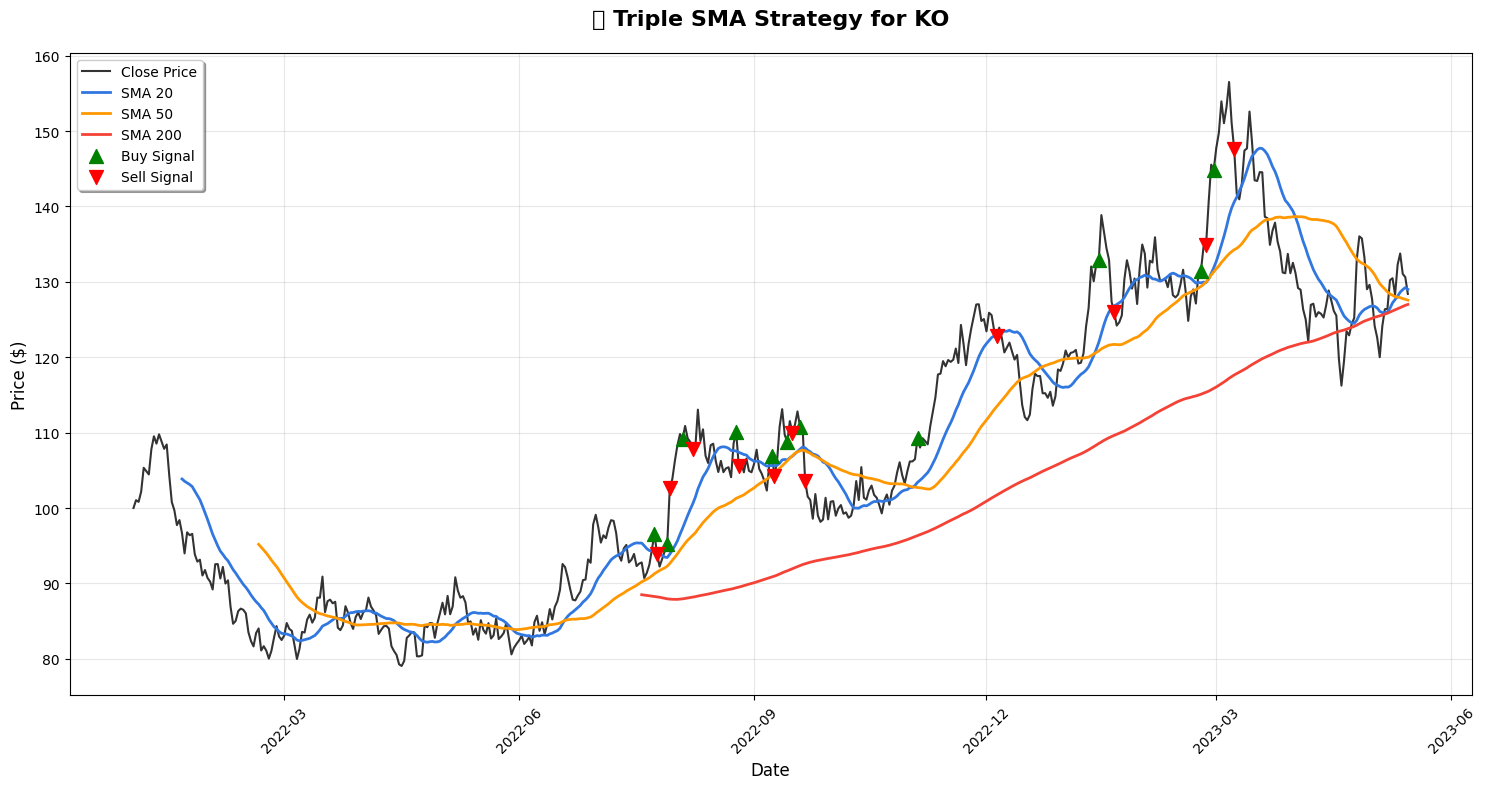


🎯 Running backtesting...

🎯 === BACKTESTING ANALYSIS FOR KO ===
🔄 Running comprehensive backtest...

📊 BACKTEST RESULTS SUMMARY:
💰 Initial Capital: $25,000.00
💰 Final Value: $24,707.09
📈 Total Return: -1.17%
📈 Annualized Return: -0.59%
⚡ Sharpe Ratio: -0.20
📉 Max Drawdown: -16.14%
📊 Volatility: 12.70%
🔄 Number of Trades: 22
🎯 Win Rate: 45.45%


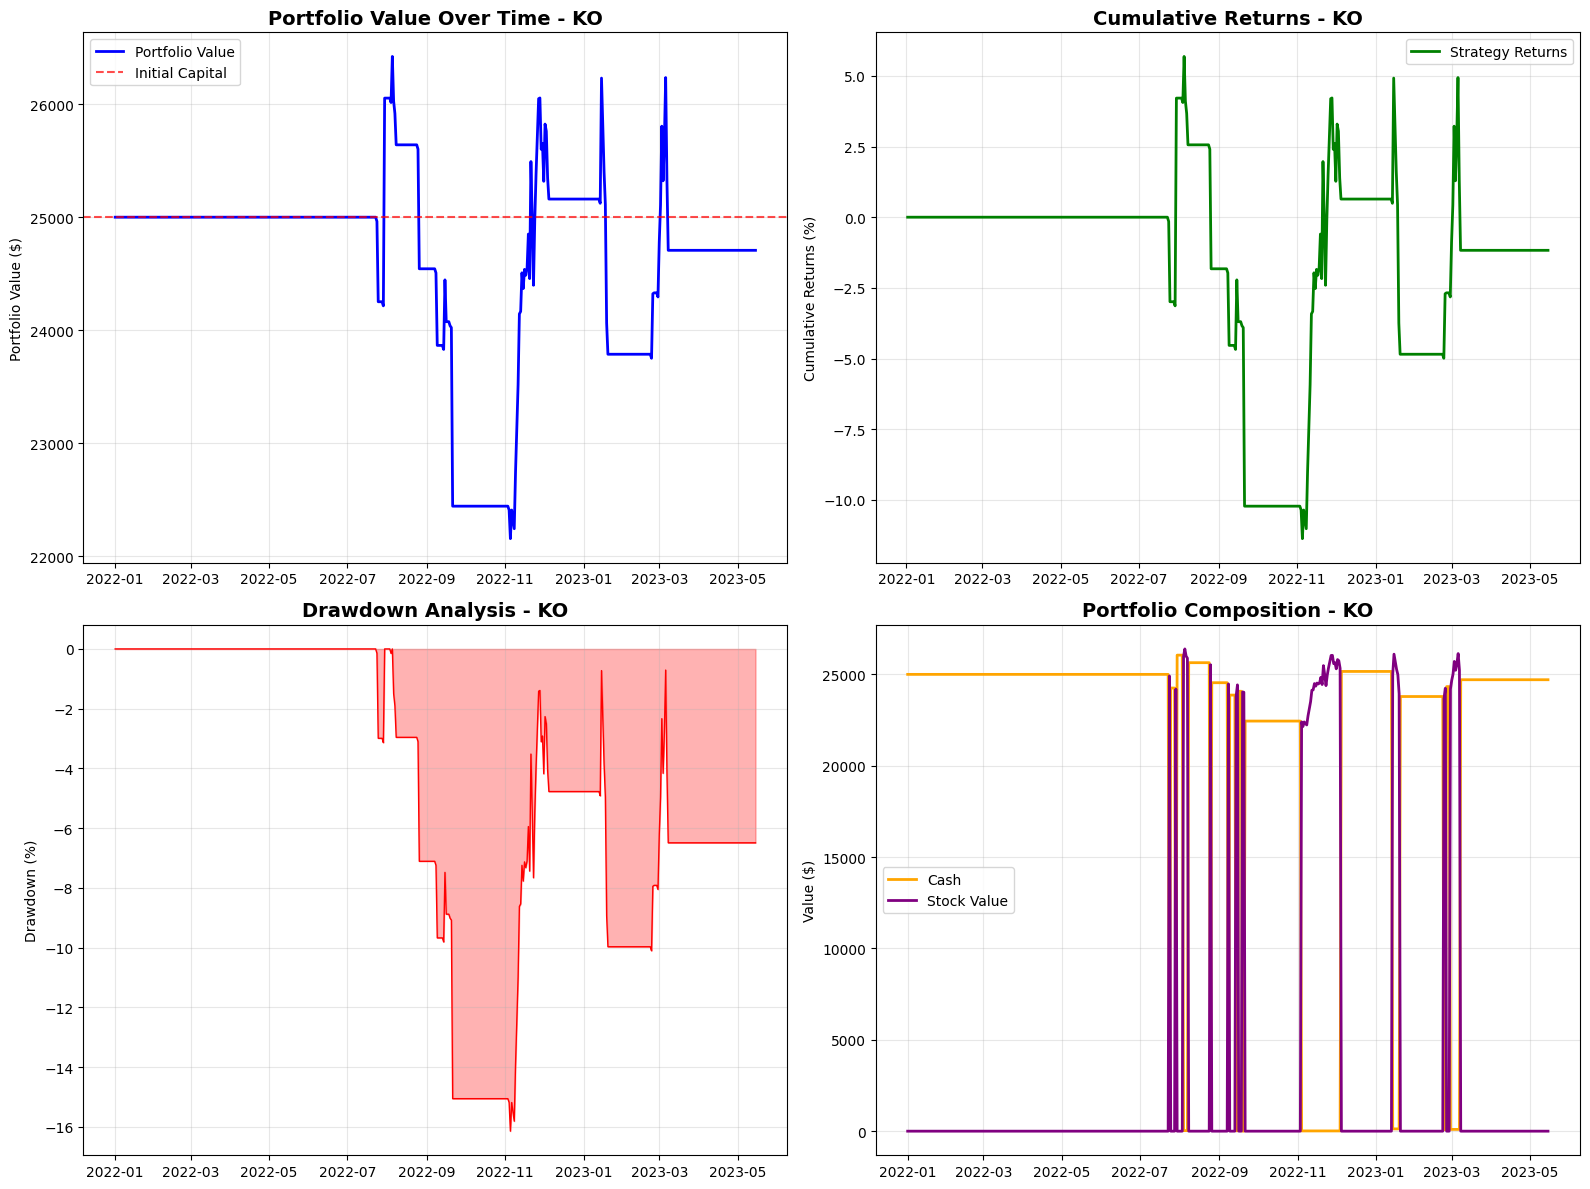


📋 RECENT TRADES (Last 10):
      date action  quantity      price  transaction_cost
2022-09-19    BUY       217 110.781949         36.059525
2022-09-21   SELL       217 103.584287         33.716685
2022-11-04    BUY       205 109.256329         33.596321
2022-12-05   SELL       205 122.853246         37.777373
2023-01-14    BUY       188 132.966432         37.496534
2023-01-20   SELL       188 126.054800         35.547453
2023-02-23    BUY       180 131.503068         35.505828
2023-02-25   SELL       180 134.919633         36.428301
2023-02-28    BUY       167 144.900290         36.297523
2023-03-08   SELL       167 147.590792         36.971493

🔍 === Generating QuantStats Reports ===

📊 Basic Performance Metrics:
📈 CAGR: 1.06%
⚡ Sharpe Ratio: 0.15
📉 Max Drawdown: -14.89%
🎯 Win Rate: 49.15%
📊 Volatility (Ann.): 12.62%

📊 Plotting Cumulative Returns...


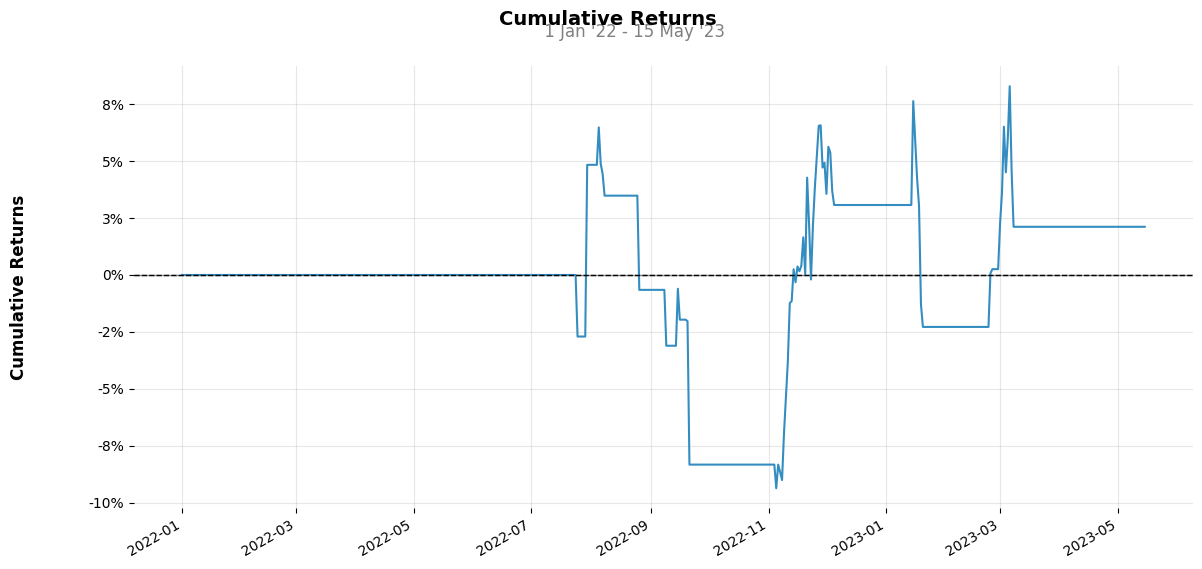

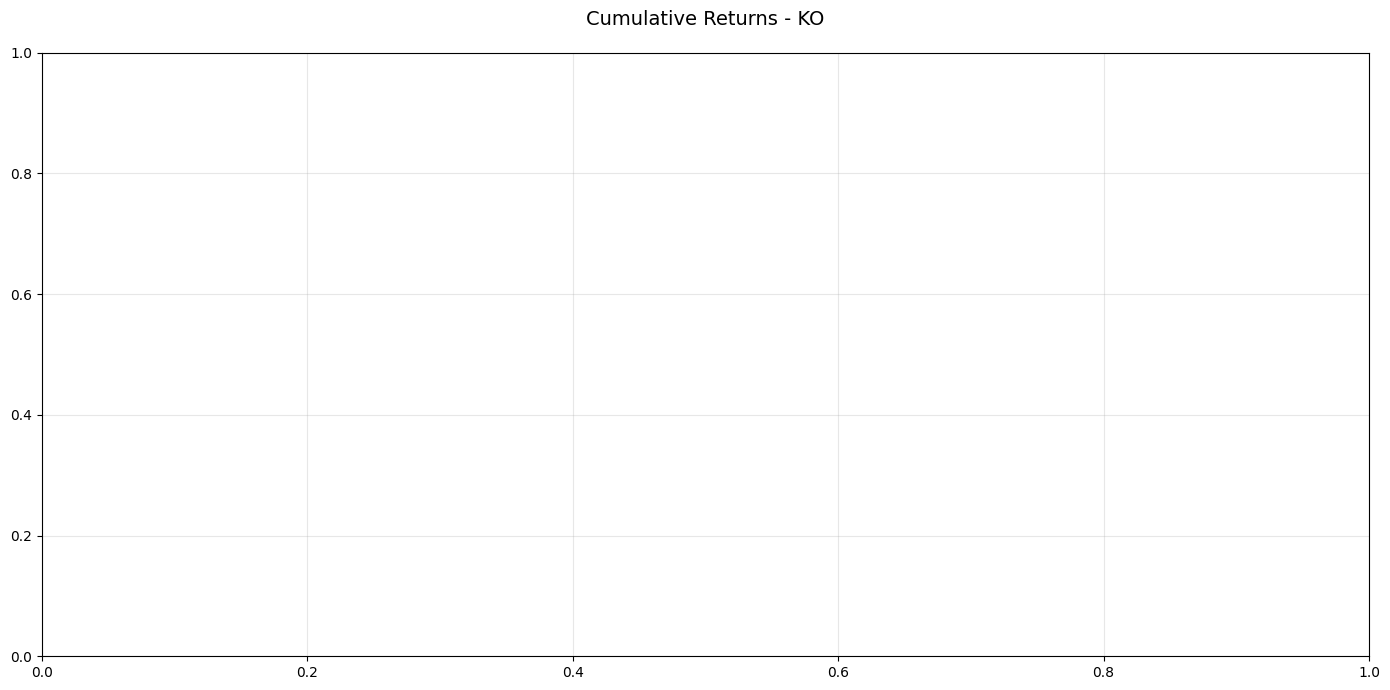


📉 Plotting Drawdowns...


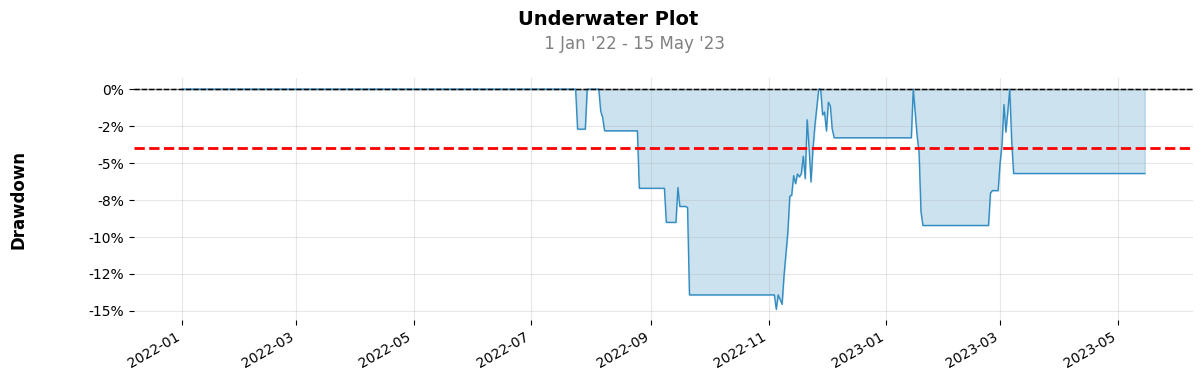

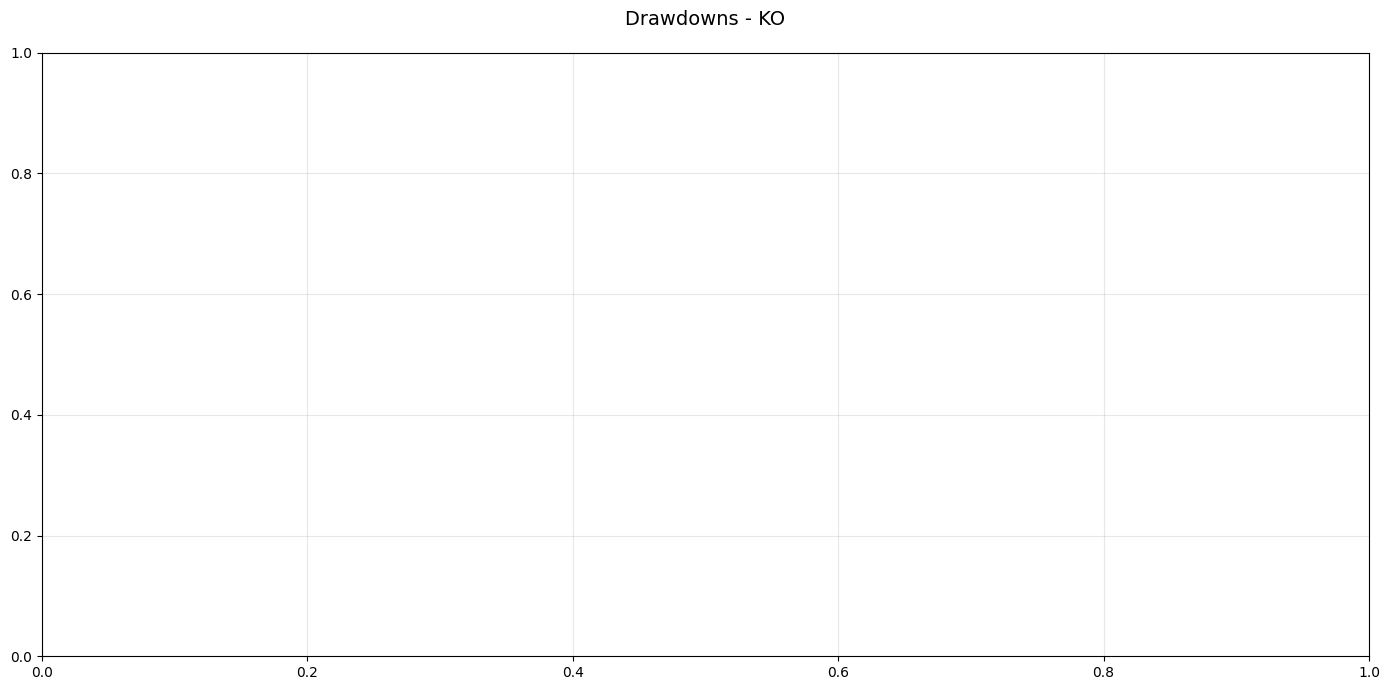


🔥 Plotting Monthly Returns Heatmap...


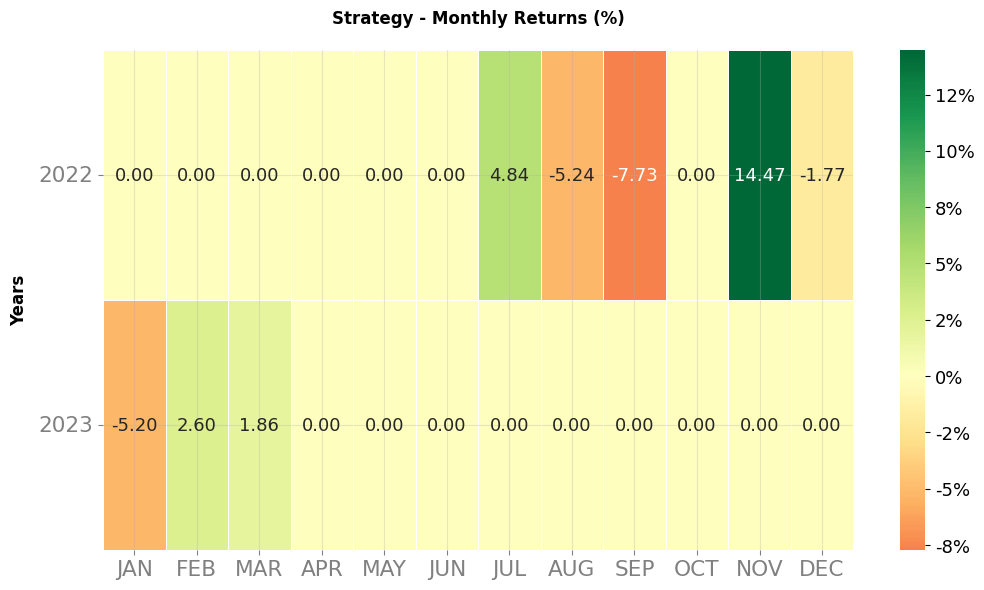

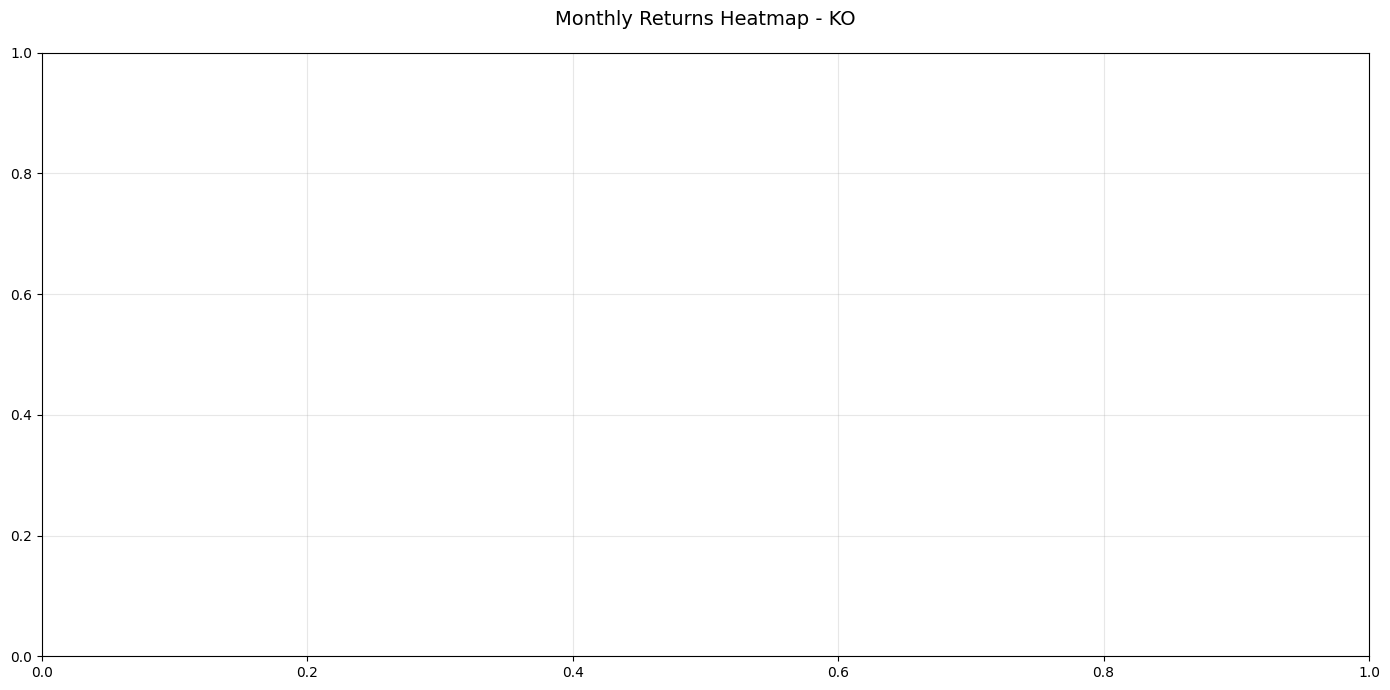


📋 Detailed Metrics:
                      Strategy
Start Period        2022-01-01
End Period          2023-05-15
Risk-Free Rate               0
Time in Market            0.12
Cumulative Return         0.02
CAGR﹪                     0.01
Sharpe                    0.15
Prob. Sharpe Ratio        0.58
Sortino                   0.22
Sortino/√2                0.15
Omega                     1.07
Max Drawdown             -0.15
Longest DD Days            113
Gain/Pain Ratio           0.07
Gain/Pain (1M)            0.18
Payoff Ratio              1.11
Profit Factor             1.07
Common Sense Ratio        0.56
CPC Index                 0.58
Tail Ratio                0.53
Outlier Win Ratio        22.16
Outlier Loss Ratio        1.45
MTD                          0
3M                        0.05
6M                        0.02
YTD                      -0.01
1Y                        0.02
3Y (ann.)                 0.01
5Y (ann.)                 0.01
10Y (ann.)                0.01
All-time (ann.)   

In [124]:
run_triple_sma_system()